## 0 Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import gpflow
from gpflow.kernels import SquaredExponential, SharedIndependent, SeparateIndependent
from gpflow.inducing_variables import SharedIndependentInducingVariables, InducingPoints
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

from GWP.BANNER.src.models.WishartProcess import WishartProcess
from GWP.BANNER.util.training_util import run_adam
from GWP.BANNER.src.kernels.PartlySharedIndependentMOK import PartlySharedIndependentMultiOutput
from GWP.BANNER.src.likelihoods.WishartProcessLikelihood import WishartLikelihood


## 1 Generate data 

In [2]:
def simulate_wishart_process(D=5, T=10, N=100, A=None, nu=None):
    """
    :param D: Number of observed variables.
    :param T: Length of time series.
    :param N: Number of samples.
    :param A: Cholesky decomposition of the Wishart scaling matrix, i.e. V=AA^T. Defaults to the identity.
    :param nu: The Wishart degrees of freedom. Defaults to D+1.
    :return: A sample from the Wishart process \Sigma(x)
    """

    def sample_gp(X, kernel, nsamples):
        """
        :param X: Input locations.
        :param kernel: GP kernel.
        :param nsamples: Number of samples.
        :return: Generates samples from a GP with known kernel.
        """

        K = kernel.K(X) + 1e-6 * np.eye(N)
        L = np.linalg.cholesky(K)
        z = np.random.normal(size=(N, nsamples))
        return np.dot(L, z)  # N x nsamples

    #
    if A is None:
        A = np.eye(D)

    # Number of latent GPs (aka degrees-of-freedom)
    if nu is None:
        nu = D + 1

    # Generate input
    X = np.tile(np.linspace(0, T, N), (D, 1)).T
   
    # True dynamic properties of each of D variables. We pick some random lengthscales and variances within some bounds.
    true_lengthscale = np.random.permutation(np.linspace(0.05 * T, 0.3 * T, num=D))
    true_variance = 1 + 0.5*np.random.uniform(size=D)

    # The true kernel is a distinct kernel for each latent GP. Across the degrees of freedom (\nu), the same kernel is
    # used.
    kernels = [SquaredExponential(lengthscales=true_lengthscale[i], variance=true_variance[i]) for i in range(D)]

    # Latent GPs
    u = np.zeros((D, nu, N))
    for i in range(D):
        u[i, :, :] = sample_gp(X, kernels[i], nsamples=nu).T

    Sigma = np.zeros((N, D, D))
    for t in range(N):
        Sigma[t, :, :] = np.dot(np.dot(A, np.dot(u[:, :, t], u[:, :, t].T)), A.T)

    return X, Sigma, true_lengthscale, true_variance

def sample_observations(Sigma, mu=None):
    """
    :param Sigma: Generalised Wishart Process, i.e. covariance process
    :param mu: Mean function.
    :return: Returns N x D matrix Y, containing one observation for each 'time point'.
    """

    N, D, _ = Sigma.shape
    if mu is None:
        mu = np.zeros(D)

    Y = np.zeros((N, D))
    for t in range(N):
        Y[t, :] = np.random.multivariate_normal(mean=mu, cov=Sigma[t, :, :])
    return Y

In [92]:
D, N, T = 3, 100, 4.0
X, Sigma_true, true_lengthscale, true_variance = simulate_wishart_process(D=D, T=T, N=N)
Y = sample_observations(Sigma_true, np.array([-3., 0, 3.]))
print(Y.shape)
print(X.shape)
print(Sigma_true)

(100, 3)
(100, 3)
[[[ 1.07684957e+00  1.98398507e+00  1.39077776e+00]
  [ 1.98398507e+00  6.40410472e+00  2.63362963e+00]
  [ 1.39077776e+00  2.63362963e+00  3.31721872e+00]]

 [[ 8.81739022e-01  1.98060189e+00  1.17554835e+00]
  [ 1.98060189e+00  7.36317769e+00  2.75509183e+00]
  [ 1.17554835e+00  2.75509183e+00  2.98999275e+00]]

 [[ 8.11222250e-01  2.00361192e+00  9.75126029e-01]
  [ 2.00361192e+00  7.39872910e+00  2.54240398e+00]
  [ 9.75126029e-01  2.54240398e+00  2.65752833e+00]]

 [[ 8.86280526e-01  1.92467283e+00  7.93723195e-01]
  [ 1.92467283e+00  5.39239707e+00  2.16794242e+00]
  [ 7.93723195e-01  2.16794242e+00  2.35434860e+00]]

 [[ 1.12239742e+00  1.41596313e+00  6.45662117e-01]
  [ 1.41596313e+00  2.43737999e+00  1.68324254e+00]
  [ 6.45662117e-01  1.68324254e+00  2.05664248e+00]]

 [[ 1.53300213e+00  4.22678347e-01  5.38186673e-01]
  [ 4.22678347e-01  1.02129400e+00  1.09740293e+00]
  [ 5.38186673e-01  1.09740293e+00  1.81414178e+00]]

 [[ 2.08835613e+00 -6.58344291e-01

(100, 3)
(100, 3)


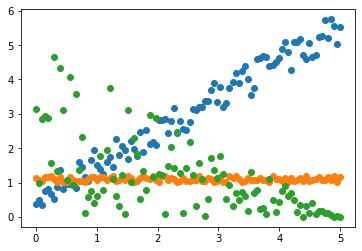

In [93]:
X = X = np.tile(np.linspace(0,5,100), (D, 1)).T
Y = np.array([np.linspace(0,5,100)+np.random.rand(100),np.ones(100)+np.random.rand(100)*0.2,np.linspace(5,0,100)*np.random.rand(100)])
Y = Y.T
print(Y.shape)
print(X.shape)
plt.scatter(X[:,0], Y[:,0])
plt.scatter(X[:,0], Y[:,1])
plt.scatter(X[:,0], Y[:,2])

## 2 Wishart inference 


The functions below are used for running the **inference**

In [94]:
def run_wishart_process_inference(data, T, iterations=10000, num_inducing=None, learning_rate=0.01, batch_size=25):
    """

    :param data: Tuple (X, Y) of input and responses.
    :param T: Last timepoint (assume we start at t=0).
    :param iterations: Number of variational inference optimization iterations.
    :param num_inducing: Number of inducing points (inducing points are in the same space as X).
    :param learning_rate: Optimization parameter.
    :param batch_size: Data is split into batches of size batch_size, for stochastic optimization (otherwise we'll run
    out of memory).
    :return: Returns a dictionary with the posterior Wishart process (with trained hyperparameters and variational
    parameters), and a list with the ELBO (loss) per iteration.
    """
    X, Y = data
    N, D = Y.shape
    if num_inducing is None:
        num_inducing = int(0.4 * N)

    model_inverse = False
    additive_noise = True

    nu = D + 1  # Degrees of freedom
    mnu = "shared" #number of mu gaussian processes
    R = 10  # samples for variational expectation
    if mnu is not None:
        mnu_val = 0
    else:
        mnu_val = 1
    latent_dim = int((nu+mnu_val) * D)

    if num_inducing == N:
        Z_init = tf.identity(X)  # X.copy()
    else:
        Z_init = np.array([np.linspace(0, T, num_inducing) for _ in range(D)]).T   # initial inducing variable locations
    Z = tf.identity(Z_init)
    iv = SharedIndependentInducingVariables(InducingPoints(Z))  # multi output inducing variables

    kernel_type = 'partially_shared'  # ['shared', 'separate', 'partially_shared']   # shares the same kernel parameters across input dimension
    kernel = SquaredExponential(lengthscales=5.)

    if kernel_type == 'shared':
        kernel = SharedIndependent(kernel, output_dim=latent_dim)
    elif kernel_type == 'separate':
        kernel = SeparateIndependent([SquaredExponential(lengthscales=1. - (i + 6) * 0.01) for i in range(latent_dim)])
    elif kernel_type == 'partially_shared':
        kernel = PartlySharedIndependentMultiOutput([SquaredExponential(lengthscales=0.5 + i * 0.5) for i in range(D)], nu=(nu+mnu_val))
    else:
        raise NotImplementedError

    # likelihood
    likelihood = WishartLikelihood(D, nu , mnu= mnu, R=R, additive_noise=additive_noise, model_inverse=model_inverse)
    # create GWP model

    wishart_process = WishartProcess(kernel, likelihood, D=D, nu=nu,  inducing_variable=iv,  mnu= mnu)

    # If num_inducing==N, we do not actually have inducing points.
    if num_inducing == N:
        gpflow.set_trainable(wishart_process.inducing_variable, False)

    elbo = run_adam(wishart_process, data, ci_niter(iterations), learning_rate, batch_size, natgrads=False, pb=True)
    return {'wishart process': wishart_process, 'ELBO': elbo}

### 2.1 train the model

In [95]:
num_iter = 4000
                        
                                 
gwp_results = run_wishart_process_inference(data=(X, Y), T=T,
                                            iterations=num_iter,
                                            num_inducing=int(0.4*N),
                                            batch_size=100)
posterior_wishart_process = gwp_results['wishart process']
elbo = gwp_results['ELBO']

#print_summary(posterior_wishart_process)



  0%|                                                 | 0/4000 [00:00<?, ?it/s]

100%|██████████████████████████████████████| 4000/4000 [02:10<00:00, 30.62it/s]


In [96]:
#printing the u used in the wishart process
num_samples = 500
testpoints = np.tile(np.linspace(0, T, N), (D, 1)).T

sigma_samples, mu_samples = posterior_wishart_process.predict_mc(testpoints, num_samples )
sigma_mean, mu = posterior_wishart_process.predict_map(testpoints)


y_samples = np.zeros_like(mu_samples)

for s in range(num_samples):
    for t in range(int(N)):
        y_samples[s,t] = np.random.multivariate_normal(mu_samples[s,t], sigma_samples[s,t])


In [97]:
sigma_samples, mu_samples = posterior_wishart_process.predict_mc(testpoints, 700 )
print(np.min(sigma_samples),np.min(np.mean(sigma_samples, axis = 0)))
print(np.cov(Y.T))
print(posterior_wishart_process.likelihood.A)

-0.32075300261299355 0.0669663103576886
[[ 2.35103500e+00  1.47948990e-04 -1.06187249e+00]
 [ 1.47948990e-04  3.30692709e-03  1.31869087e-04]
 [-1.06187249e+00  1.31869087e-04  1.15960022e+00]]
<Parameter: dtype=float64, shape=[3], fn="softplus", numpy=array([1., 1., 1.])>


In [106]:
def partial_correlations(Sigma):
    '''
    param Sigma: RxTxDxD matrix of covariances
            R: number of samples
            T: number of time steps
            D: number of output dimensions
    returns par_cor: RxTxDxD  partial correlation matrix 
    '''
    par_cor = np.ones_like(Sigma)
    print(Sigma.shape)
    precision = np.linalg.inv(Sigma)
    
    n_sample = Sigma.shape[0]
    n_time=Sigma.shape[1]
    n_dim = Sigma.shape[2]
    for s in range(n_sample):
        for t in range(n_time):
            for i in range(n_dim):
                for j in range(i+1, n_dim):
                    if i != j:
                        par_cor[s,t,i,j] = -precision[s,t,i,j]/(np.sqrt(precision[s,t,i,i])*np.sqrt(precision[s,t,j,j]))
                        par_cor[s,t,j,i] = par_cor[s,t,i,j]
    print()
    return par_cor
        
def compute_networks(Sigma, Symptoms):
    edges = partial_correlations(Sigma)
    print("edges",edges)
print(np.reshape(np.cov(Y.T),(1,3,3)))
compute_networks(sigma_samples, y_samples)
# print("cov", np.cov(Y.T))
# print("K",np.linalg.inv(np.cov(Y.T)))

[[[ 2.35103500e+00  1.47948990e-04 -1.06187249e+00]
  [ 1.47948990e-04  3.30692709e-03  1.31869087e-04]
  [-1.06187249e+00  1.31869087e-04  1.15960022e+00]]]
(700, 100, 3, 3)
edges [[[[ 1.         -0.31716685  0.58381047]
   [-0.31716685  1.          0.62050001]
   [ 0.58381047  0.62050001  1.        ]]

  [[ 1.         -0.16823795  0.56017486]
   [-0.16823795  1.          0.54645454]
   [ 0.56017486  0.54645454  1.        ]]

  [[ 1.         -0.05162302  0.52904629]
   [-0.05162302  1.          0.48673835]
   [ 0.52904629  0.48673835  1.        ]]

  ...

  [[ 1.          0.96473958 -0.30952634]
   [ 0.96473958  1.          0.43815204]
   [-0.30952634  0.43815204  1.        ]]

  [[ 1.          0.96245433 -0.30453592]
   [ 0.96245433  1.          0.4395142 ]
   [-0.30453592  0.4395142   1.        ]]

  [[ 1.          0.96099624 -0.31618516]
   [ 0.96099624  1.          0.45702891]
   [-0.31618516  0.45702891  1.        ]]]


 [[[ 1.          0.25603467 -0.16644586]
   [ 0.25603467  1.

In [84]:
Sigma  = np.reshape(np.cov(Y.T),(1,3,3))
np.matmul(Sigma,np.linalg.inv(Sigma))
X = c(2,4,15,20)
Y = c(1,2,3,4)
Z = c(0,0,1,1)

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-6.67868538e-17,  1.00000000e+00, -3.12250226e-17],
        [-2.22044605e-16,  0.00000000e+00,  1.00000000e+00]]])

In [8]:
mu_y = np.mean(y_samples,axis = 0)
var_y = np.var(y_samples, axis = 0 )


(100, 1)
(100, 3)
(100, 3)
(3, 100)
(3, 100)


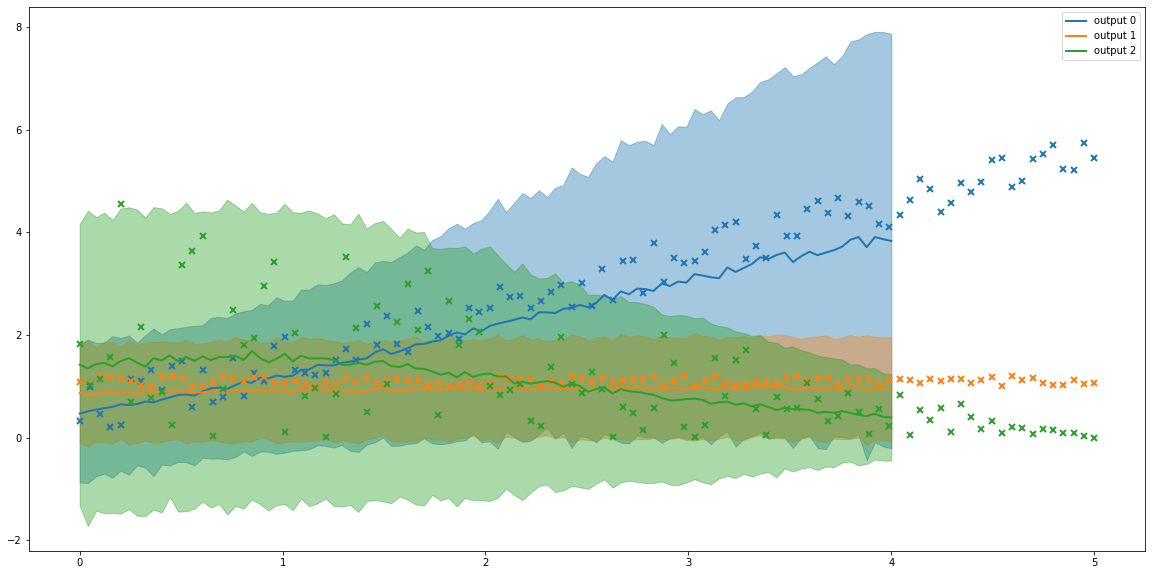

In [9]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(Xtest, mus, vs, X, Y):
    plt.figure(figsize=(20, 10))
    for i, (mu, var) in enumerate(zip(mus, vs)):
        (line,) = plt.plot(X[:,i], Y[:,i], "x", mew=2)
        label = "output " + str(i)
        mu = mu[:,None]
        var = var[:,None]
        plot_gp( Xtest, mu, var ,line.get_color(), label)
    plt.legend()
    plt.show

Xtest = np.linspace(0,4,100)[:,None]
print(Xtest.shape)
print(X.shape)
print(Y.shape)
print(mu_y.T.shape)
print(var_y.T.shape)
plot(Xtest, mu_y.T, var_y.T, X , Y)

In [10]:
def plot_loss(num_iter, loss):
    x = np.linspace(1, num_iter, len(loss))
    fig = plt.figure()
    plt.plot(x, loss, label='ELBO')
    plt.xlim([x[0], x[-1]])
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')
    plt.title('Training convergence')
    plt.tight_layout()


#
def plot_wishart_process_sample(X, Sigma):
    N, D, _ = Sigma.shape
    c1 = '#363537'
    c2 = '#EF2D56'
    fig, axes = plt.subplots(nrows=D, ncols=D, sharex=True, sharey=True, figsize=(10, 10))
    x = X[:, 0]

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]
            if j < i:
                ax.axis('off')
            else:
                ax.plot(x, Sigma[:, i, j], color=c1, lw=2, label='Ground truth')
                ax.set_xlim([x[0], x[-1]])
                ax.set_title('$\sigma_{{{:d},{:d}}}(t)$'.format(i + 1, j + 1), fontsize=20)
    return fig, axes


#
def plot_wishart_predictions(samples, X, axes=None, plot_individuals=0):
    posterior_expectation = tf.reduce_mean(samples, axis=0).numpy()
    posterior_variance = tf.math.reduce_variance(samples, axis=0).numpy()

    c1 = '#363537'
    c2 = '#EF2D56'

    _, D = X.shape
    x = X[:, 0]
    if axes is None:
        fig, axes = plt.subplots(nrows=D, ncols=D, sharex=True, sharey=True, figsize=(10, 10))

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]
            if j < i:
                ax.axis('off')
            else:
                mean = posterior_expectation[:, i, j]
                intv = 1.96*np.sqrt(posterior_variance[:, i, j])
                ax.plot(x, mean, lw=2, c=c2, label='BANNER posterior mean')
                ax.fill_between(x, mean - intv, mean + intv, color=c2, alpha=0.2, label='BANNER 95\% HDI')
                if plot_individuals > 0:
                    ixs = np.random.randint(0, samples.shape[0], size=plot_individuals)
                    for ix in ixs:
                        ax.plot(x, samples[ix, :, i, j].numpy(), c=c2, alpha=0.4, lw=0.5)
                ax.set_xlim([x[0], x[-1]])


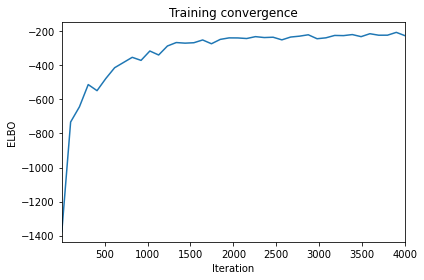

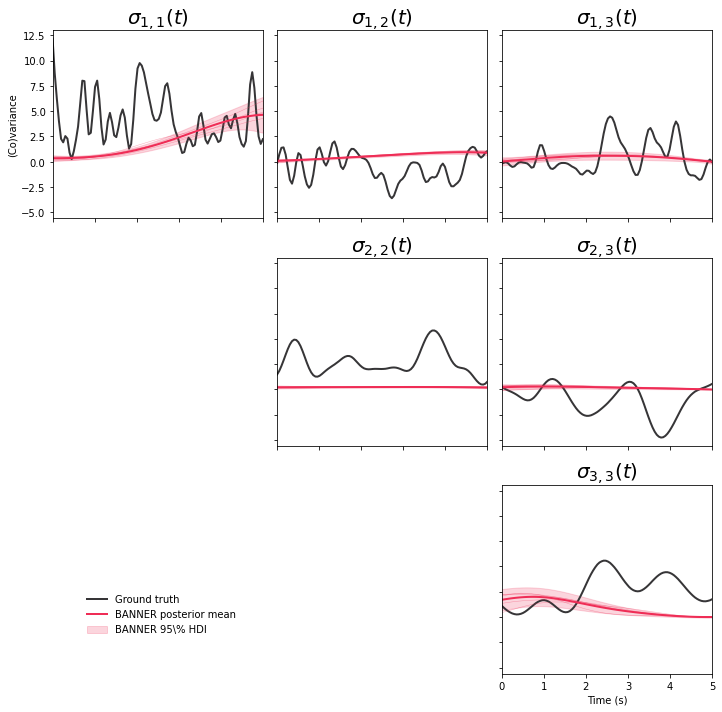

In [12]:
elbo = gwp_results['ELBO']

plot_loss(num_iter, elbo)

num_samples = 5000

fig, axes = plot_wishart_process_sample(X, Sigma_true)
samples , _= posterior_wishart_process.predict_mc(X, num_samples) #(num_samples, N, D, D)
plot_wishart_predictions(samples=samples, X=X, axes=axes, plot_individuals=5)
# plot_sliding_window(sliding_window_inv_wishart_mean, sliding_window_inv_wishart_var, axes=axes)

axes[-1, -1].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('(Co)variance')
handles, labels = axes[-1, -1].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=1, loc='lower left', bbox_to_anchor=(0.1, 0.10), frameon=False)
plt.tight_layout()
plt.show()

# for i in range(D):
#     print('Variable {:d}'.format(i))
#     print('True lengthscale: {:0.3f}'.format(true_lengthscale[i]))
#     print('Estimated lengthscale: {:0.3f}'.format(posterior_wishart_process.kernel.kernels[i].kernel.lengthscales.numpy().item()))
#     print('True variance: {:0.3f}'.format(true_variance[i]))
#     print('Estimated variance: {:0.3f}'.format(posterior_wishart_process.kernel.kernels[i].kernel.variance.numpy().item()))

# 3 Multi-output GP

In [14]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from gpflow.ci_utils import ci_niter

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

In [15]:

Xa = X[:,0][:,None]
Xb = X[:,1][:,None]
Xc = X[:,2][:,None]
Ya = Y[:,0][:,None]
Yb = Y[:,1][:,None]
Yc = Y[:,2][:,None]


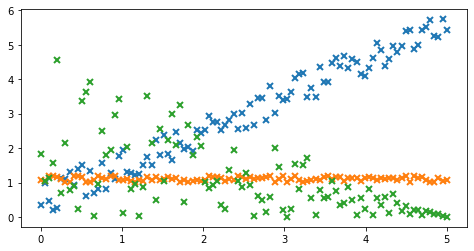

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(Xa,Ya,"x", mew=2)
_ = plt.plot(Xb,Yb, "x", mew=2)
_ = plt.plot(Xc,Yc, "x", mew=2)

In [17]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.vstack((np.hstack((Xa, np.zeros_like(Xa))), np.hstack((Xb, np.ones_like(Xb))))),np.hstack((Xc, np.ones_like(Xc)*2))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_augmented = np.vstack((np.vstack((np.hstack((Ya, np.zeros_like(Ya))), np.hstack((Yb, np.ones_like(Yb))))),np.hstack((Yc, np.ones_like(Yc)*2))))


In [18]:
output_dim = 3  # Number of outputs
rank = 3 # Rank of W:  it is the number of degrees of correlation between the outputs.

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

kern = k * coreg #changep

In [19]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian(),gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = ci_niter(5000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


      fun: 25.134709045612617
 hess_inv: <45467x45467 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.57214537e-02, -9.28595055e-02, -2.21953605e-02, ...,
        1.25519156e-04,  3.33941613e-04, -1.88167471e-05])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 5492
      nit: 5000
     njev: 5492
   status: 1
  success: False
        x: array([ 5.70098878e+01,  4.07445692e+00,  5.49656256e+00, ...,
       -4.58442644e-02, -4.66928837e-02,  9.76212028e-01])

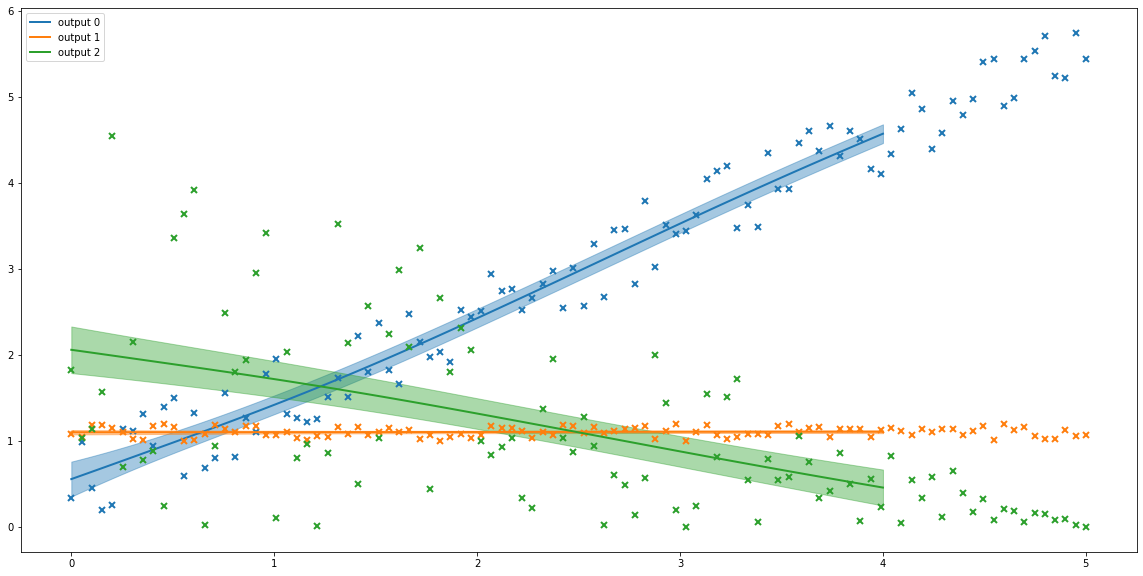

In [20]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(Xtest, mus, vs, X, Y):
    plt.figure(figsize=(20, 10))
    for i, (mu, var) in enumerate(zip(mus, vs)):
        (line,) = plt.plot(X[:,i], Y[:,i], "x", mew=2)
        label = "output " + str(i)
        plot_gp( Xtest, mu, var ,line.get_color(), label)
    plt.legend()

Xtest = np.linspace(0,4,100)[:,None]
mus = []
vs=  []
for out in range(output_dim):
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest)*out)))
    mus.append(mu)
    vs.append(var)

plot(Xtest, mus, vs, X , Y)


In [21]:
print(Y_augmented)
mu, var = m.predict_f(X_augmented)
print(mu, var.shape)

[[3.33435051e-01 0.00000000e+00]
 [9.87838177e-01 0.00000000e+00]
 [4.53769000e-01 0.00000000e+00]
 [2.03609268e-01 0.00000000e+00]
 [2.54809294e-01 0.00000000e+00]
 [1.14227132e+00 0.00000000e+00]
 [1.11341845e+00 0.00000000e+00]
 [1.31429451e+00 0.00000000e+00]
 [9.37783843e-01 0.00000000e+00]
 [1.39561368e+00 0.00000000e+00]
 [1.49763581e+00 0.00000000e+00]
 [5.95355204e-01 0.00000000e+00]
 [1.32493024e+00 0.00000000e+00]
 [6.89928917e-01 0.00000000e+00]
 [8.02368142e-01 0.00000000e+00]
 [1.55652546e+00 0.00000000e+00]
 [8.18309037e-01 0.00000000e+00]
 [1.26317526e+00 0.00000000e+00]
 [1.10652032e+00 0.00000000e+00]
 [1.78148007e+00 0.00000000e+00]
 [1.95258921e+00 0.00000000e+00]
 [1.31834478e+00 0.00000000e+00]
 [1.26744765e+00 0.00000000e+00]
 [1.22154650e+00 0.00000000e+00]
 [1.26092251e+00 0.00000000e+00]
 [1.51523381e+00 0.00000000e+00]
 [1.73123480e+00 0.00000000e+00]
 [1.51497485e+00 0.00000000e+00]
 [2.22245718e+00 0.00000000e+00]
 [1.80346568e+00 0.00000000e+00]
 [2.373277

tf.Tensor(
[[0.55785055]
 [0.60019532]
 [0.64266044]
 [0.68525323]
 [0.72797596]
 [0.7708066 ]
 [0.81370001]
 [0.85662494]
 [0.89956995]
 [0.94254666]
 [0.9855811 ]
 [1.02872632]
 [1.07205282]
 [1.11561563]
 [1.15946619]
 [1.20364124]
 [1.24816596]
 [1.29307116]
 [1.33837388]
 [1.38408338]
 [1.4302009 ]
 [1.47674273]
 [1.52374966]
 [1.57125936]
 [1.61929582]
 [1.66786529]
 [1.71695859]
 [1.76655825]
 [1.81664003]
 [1.86717268]
 [1.91813939]
 [1.96952796]
 [2.02134194]
 [2.0735784 ]
 [2.12621948]
 [2.17925682]
 [2.23268095]
 [2.28647275]
 [2.34059663]
 [2.39499987]
 [2.44963078]
 [2.50443949]
 [2.55938364]
 [2.61444221]
 [2.66960864]
 [2.72488389]
 [2.78026633]
 [2.83575266]
 [2.89134173]
 [2.94703337]
 [3.00281652]
 [3.0586759 ]
 [3.1145822 ]
 [3.17050774]
 [3.22641512]
 [3.28227752]
 [3.33807749]
 [3.39378921]
 [3.44939751]
 [3.50487517]
 [3.56019154]
 [3.61531356]
 [3.67020429]
 [3.72483075]
 [3.77917791]
 [3.83325352]
 [3.88707917]
 [3.94066209]
 [3.99399572]
 [4.04705911]
 [4.09983

# 4 MGARCH

In [22]:
#source: https://quant.stackexchange.com/questions/20687/multivariate-garch-in-python
#http://www.unstarched.net/r-examples/rmgarch/
# question about getting var out of the model
# https://stackoverflow.com/questions/41149441/how-to-get-var-output-for-multivariate-dcc-garch-using-rmgarch-package-in-r


Train the mgarch model and compute the covariance

In [23]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro 

import numpy as np
import pandas as pd
from rpy2.robjects.conversion import localconverter

df = pd.DataFrame(Y, columns = ['Column_A','Column_B','Column_C'])
pd_rets = pd.DataFrame(df)

# compute DCC-Garch in R using rmgarch package
pandas2ri.activate()
with localconverter(ro.default_converter + pandas2ri.converter):
    r_rets = ro.conversion.py2rpy(pd_rets)
 # convert the daily returns from pandas dataframe in Python to dataframe in R
r_dccgarch_code = """
                library('rmgarch')
                function(r_rets, n_days){
                        univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                                                    variance.model = list(garchOrder = c(1,1),
                                                                        variance.targeting = FALSE, 
                                                                        model = "sGARCH"),
                                                    distribution.model = "norm")
                        n <- dim(r_rets)[2]
                        dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                                            dccOrder = c(1,1),
                                            distribution = "mvnorm")
                        dcc_fit <- dccfit(dcc_spec, data=r_rets)
                        gogarch_spec <-gogarchspec(mean.model = list(model = 'VAR', lag = 1), distribution.model = 'mvnorm', ica = 'fastica')
                        show(go_fit)
                        forecasts <- dccforecast(dcc_fit, n.ahead = n_days)
                        covariances = rcov(gogarch_fit)
                        list(dcc_fit, forecasts@mforecast$H, covariances)
                }
                """
r_dccgarch = ro.r(r_dccgarch_code)
n_days= 4
r_res = r_dccgarch(r_rets,n_days)

pandas2ri.deactivate()
# end of R

r_dccgarch_model = r_res[0] # model parameters

r_forecast_cov = r_res[1] # forecasted covariance matrices for n_days

r_cov = r_res[2] # the covarince matrices for known points

# access and transform the covariance matrices in R format
n_cols = pd_rets.shape[1] # get the number of stocks in pd_rets
n_elements = n_cols*n_cols # the number of elements in each covariance matrix
n_matrix = int(len(r_forecast_cov[0])/(n_elements))
print(n_matrix) # this should be equal to n_days

# sum the daily forecasted covariance matrices 
cov_matrix = 0
for i in range(n_matrix):
    i_matrix = np.array([v for v in r_forecast_cov[0][i*n_elements:(i+1)*n_elements]])
    i_matrix = i_matrix.reshape(n_cols,n_cols)    
    cov_matrix += i_matrix


R[write to console]: Loading required package: rugarch

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: 'rugarch'


R[write to console]: The following object is masked from 'package:stats':

    sigma




4


transform the r object ino a numpy array

In [24]:
#transform the r object ino a numpy array
mgarch_sigma = np.zeros((N,D,D))
for i in range(N*D*D):
    mgarch_sigma[i//(D*D),(i%(D*D))//D, (i%(D*D))%D]= r_cov[i]


Compute mean for mgarch


In [25]:
mgarch_y_samples = np.zeros_like(y_samples)
for i in range(mgarch_y_samples.shape[0]):
    for t in range(int(N)):
        mgarch_y_samples[i,t] = np.random.multivariate_normal([0,0,0], mgarch_sigma[t])

# 5 results

Below are functions used for **plotting**

B = [[ 90.66673438   0.5881586  -35.85259249]
 [  0.5881586    0.13823746  -0.23265447]
 [-35.85259249  -0.23265447  15.04376108]]


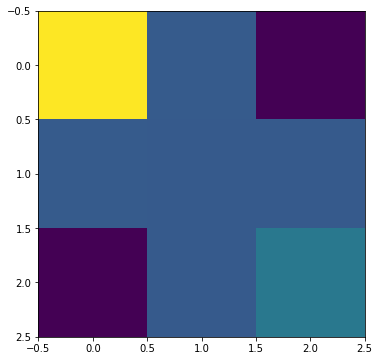

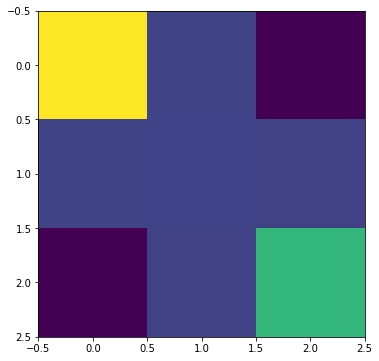

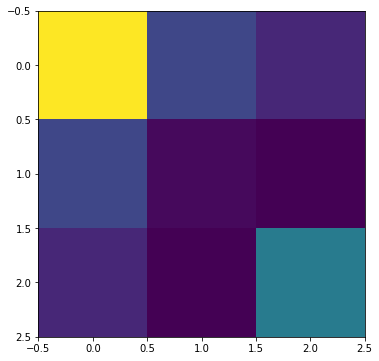

tf.Tensor(
[[2.08978602 0.59257797 0.39670227]
 [0.59257797 0.23230433 0.18629294]
 [0.39670227 0.18629294 0.9758226 ]], shape=(3, 3), dtype=float64)
tf.Tensor(
[[ 2.3393425   0.0105485  -0.585084  ]
 [ 0.0105485   0.00300697 -0.00296283]
 [-0.585084   -0.00296283  1.35133506]], shape=(3, 3), dtype=float64)


In [29]:
B = coreg.output_covariance().numpy()

print("B =", B)
_ = plt.imshow(B)
plt.show()

# avg_sigma = tf.reduce_mean(Sigma_true, axis = 0)
# _ = plt.imshow(avg_sigma)
# plt.show()

avg_mgarch = tf.reduce_mean(mgarch_sigma, axis = 0)
_ = plt.imshow(avg_mgarch)
plt.show()
avg_gwp = tf.reduce_mean(samples, axis=0).numpy()
avg_gwp = tf.reduce_mean(avg_gwp, axis =0)
_ = plt.imshow(avg_gwp)
plt.show()
print(avg_gwp)
print(avg_mgarch)


Mean squared error



In [ ]:
def MSE(Ytest, predictions ):
    mse = np.zeros_like(predictions)
    for sample in range(predictions.shape[0]):
        for iy,y in enumerate(Ytest):
            mse[sample,iy] = (y - predictions[sample,iy])**2
    return np.mean(mse, axis = 1)

In [ ]:
def correlation(Ytest, predictions):
    corr = np.corrcoef(Ytest, predictions)
    corr = np.mean(corr, axis = 0)
    return corr
        

In [ ]:
Y_test = sample_observations(Sigma_true, np.array([-3., 0, 3.]))
Y_test.shape
mse = MSE(Y_test, y_samples)
print(mse)
mean_mse = np.mean(mse, axis = 0)
var_mse = np.var(mse, axis =0)

likelihood

In [ ]:
AF = np.ones((10,3,2))
affa = np.matmul(AF, np.transpose(AF, [0, 2, 1]))
affab = np.sum(AF, axis = -1)
print(affa)
mu = 1